In [1]:
import sys
sys.path.append("../../src")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.helper import result_handler
import os
from utils.plot_functions import set_style, set_size
import pathlib
import shutil
os.chdir("../..")
os.getcwd()

'c:\\Users\\jonas\\OneDrive - Danmarks Tekniske Universitet\\KID\\7. Semester\\Bachelor Projekt\\Bachelorproject'

In [2]:
def find_csv(search_folder, starts="1000"):
    files = []

    for (dirpath, dirnames, filenames) in os.walk(search_folder):
        for f in filenames:
            if (pathlib.Path(f).suffix == ".csv") and (f.startswith(starts)) and (not "loss" in f):
                files.append(os.path.join(dirpath, f))

    return files


def concat_results(paths_to_dfs: list, save_path: str = None):
    df = None
    for path in paths_to_dfs:
        # Apparantly pandas prefer speed over precision:
        # https://stackoverflow.com/questions/47368296/pandas-read-csv-file-with-float-values-results-in-weird-rounding-and-decimal-dig
        new_df = pd.read_csv(path, index_col=0, header=0)
        new_df=new_df[["test_acc","epoch","last_model","TaskLearner","ActiveLearn","train_size","n", "lr", "weight_decay"]]
        #new_df['ActiveLearn'] = path.split('\\')[4]
        df = result_handler(df, new_df)

    if save_path:
        df.to_csv(os.path.join(save_path, "results.csv"))
    return df


def add_last_and_best(df, save_path: str = False):
    # Ensure last_model is assigned due to earlier errors
    df["last_model"] = False * len(df)
    for i in range(1, len(df)):
        if df.loc[i, "epoch"] == 1:
            df.loc[i - 1, "last_model"] = True
    df.loc[len(df) - 1, "last_model"] = True

    # Look at best model. Note that the next sampled are using the last model
    df["best_model"] = False * len(df)
    intervals = [-1] + df.index[df["last_model"] == True].tolist()
    for i in range(len(intervals) - 1):
        start = intervals[i] + 1
        end = intervals[i + 1] + 1
        df.best_model[df.test_acc[start:end].idxmax()] = True
    if save_path:
        df.to_csv(os.path.join(save_path, "WSA1K.csv"))
    return df

def make_latex(save_path, df):
    df_mean = df.groupby(["Start", "train_size"]).mean()["test_acc"]
    df_mean = df_mean.round(3)
    df_sem = df.groupby(["Start", "train_size"]).sem()["test_acc"] * 2
    df_sem = df_sem.round(3)
    df_stats = pd.concat([df_mean, df_sem], axis=1)
    df_stats.columns.values[0] = "Mean"
    df_stats.columns.values[1] = "CI 95"
    df_stats.index.names = ["Initial Size", "Train Size"]
    df_stats = df_stats.rename(index={"Uncertain+Random": "Unc. & ran."})
    print("Saving to:", save_path)
    with open(save_path, "w") as tf:
        tf.write(df_stats.to_latex())

c:\Users\jonas\anaconda3\lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.25187832, 0.71827158, 0.67872193)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
c:\Users\jonas\anaconda3\lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.25307401, 0.23772973, 0.48316271)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
C:\Users\jonas\AppData\Local\Temp\ipykernel_23188\1220084632.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Saving to: docs/results\ESC50_starts\start_Uncertainty.tex


c:\Users\jonas\anaconda3\lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.25187832, 0.71827158, 0.67872193)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
c:\Users\jonas\anaconda3\lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.25307401, 0.23772973, 0.48316271)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
C:\Users\jonas\AppData\Local\Temp\ipykernel_23188\1220084632.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Saving to: docs/results\ESC50_starts\start_Uncertain+Random.tex


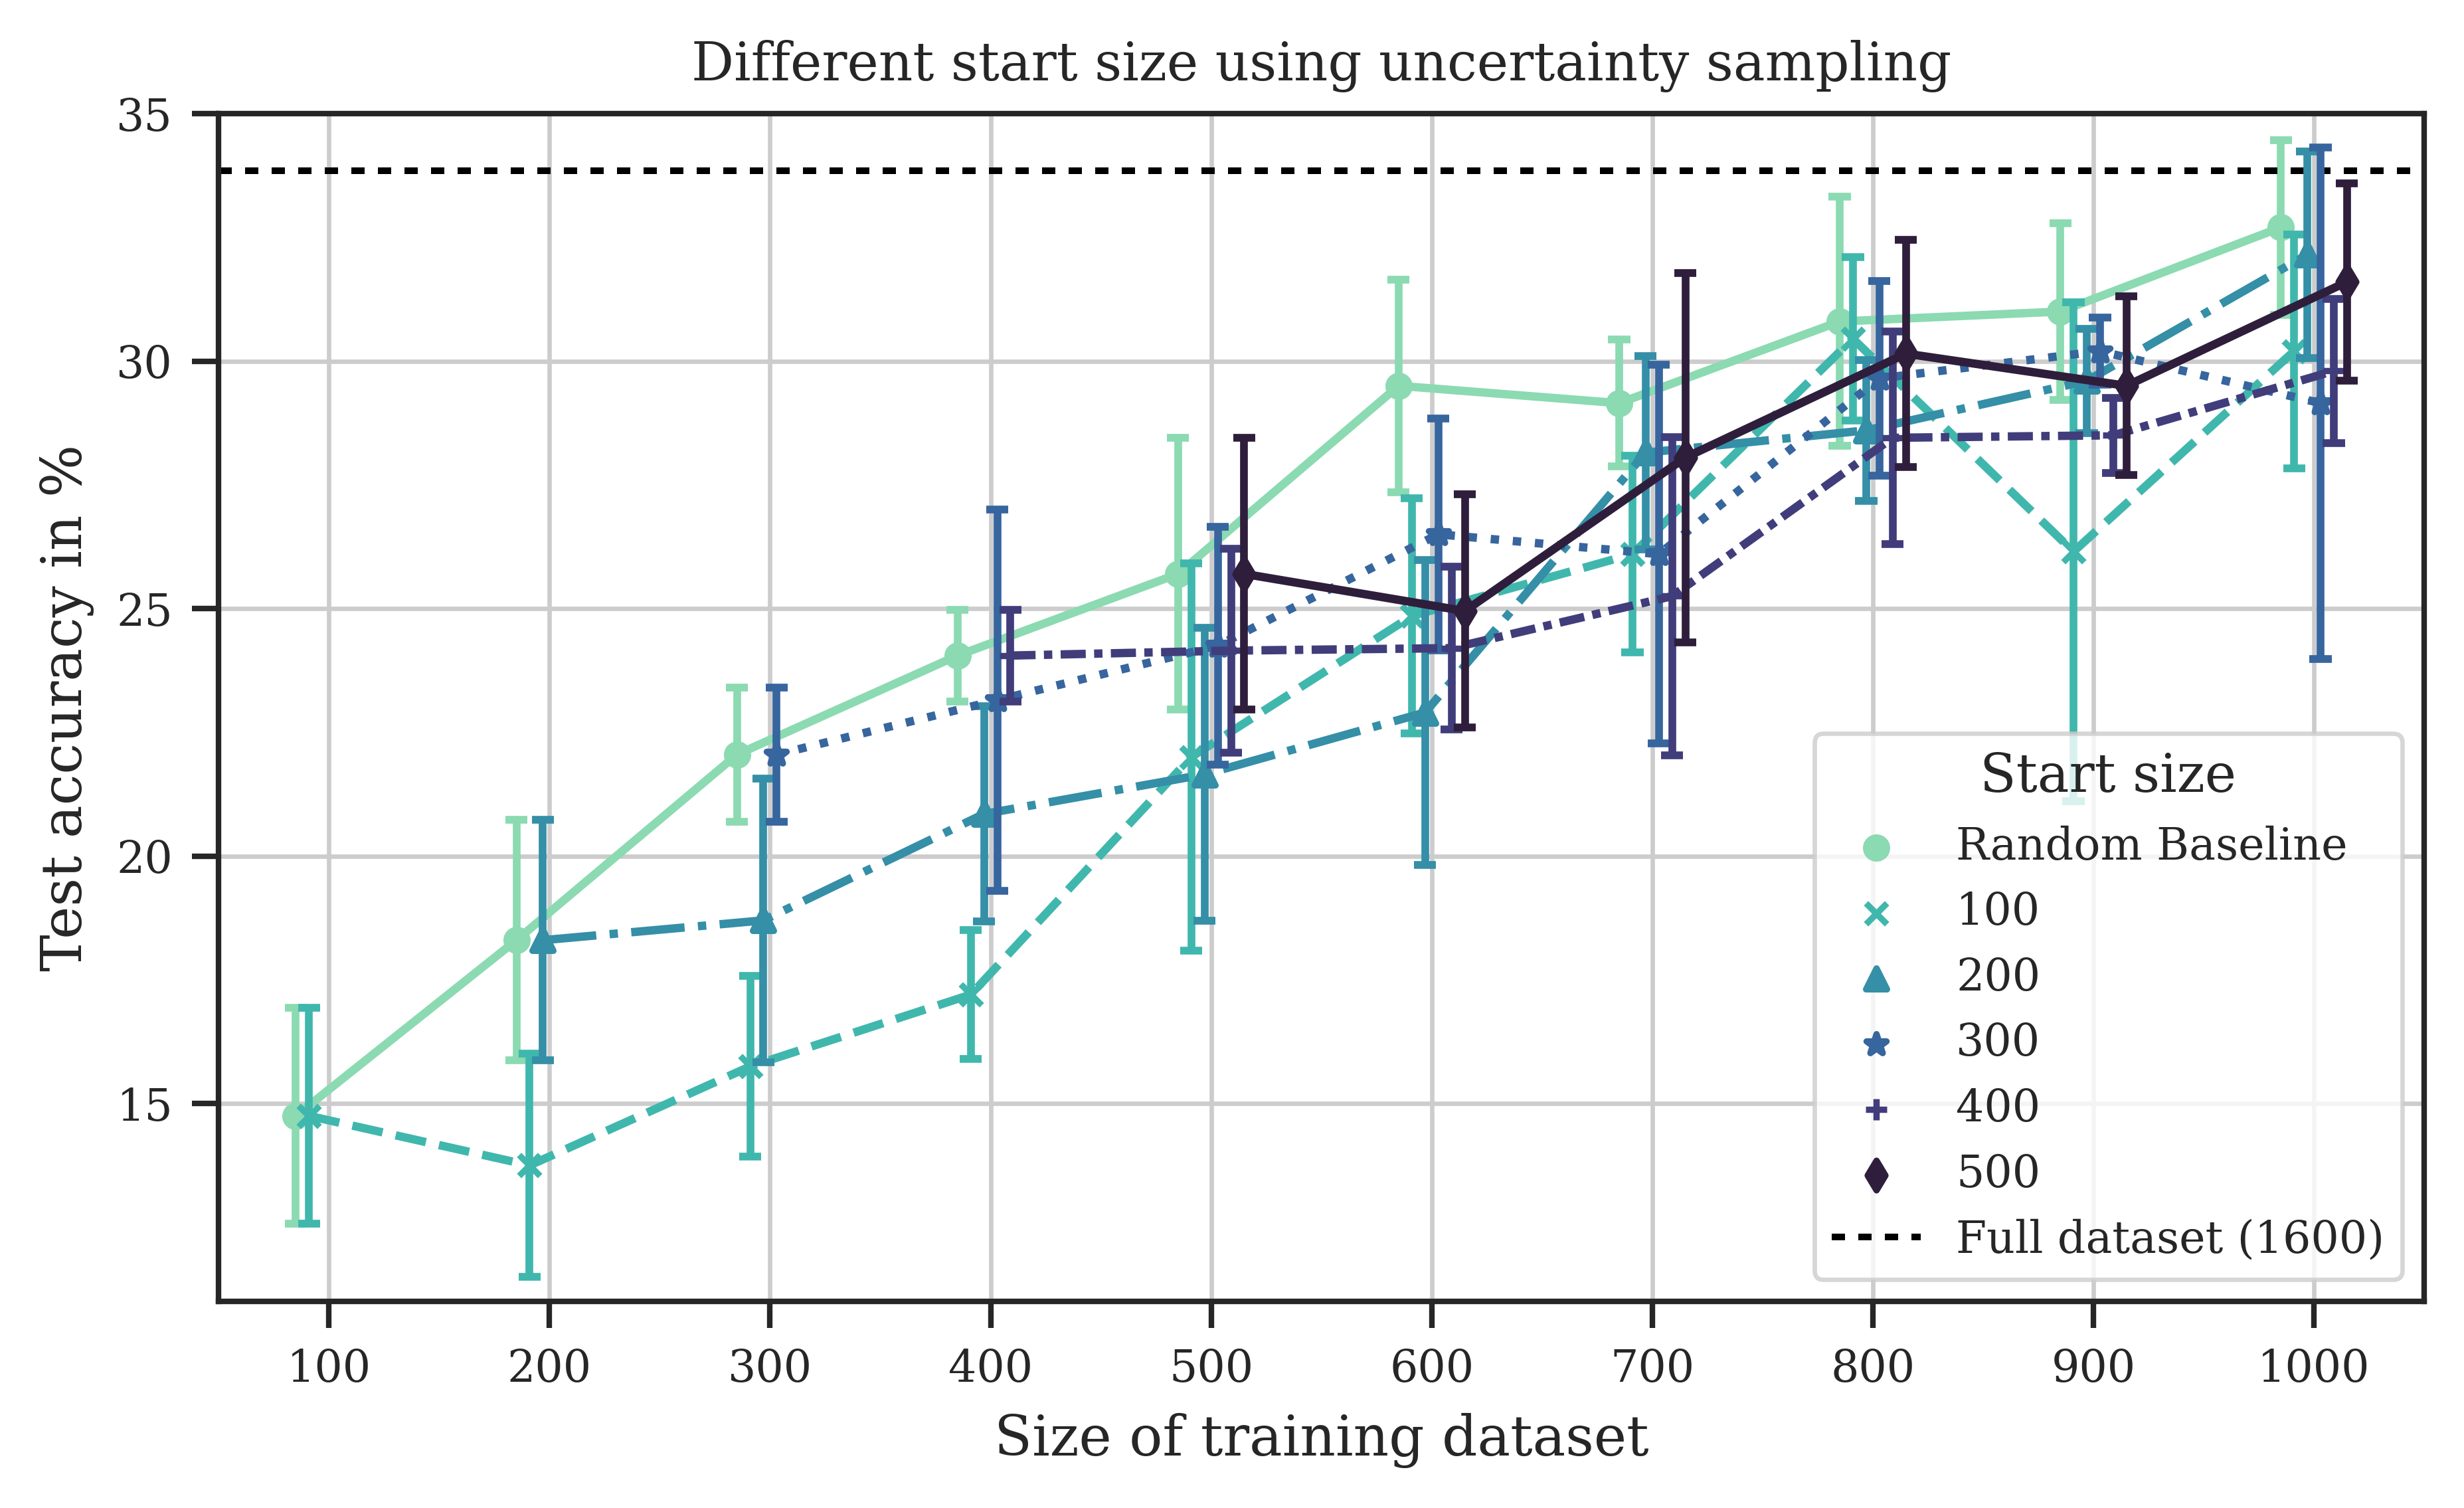

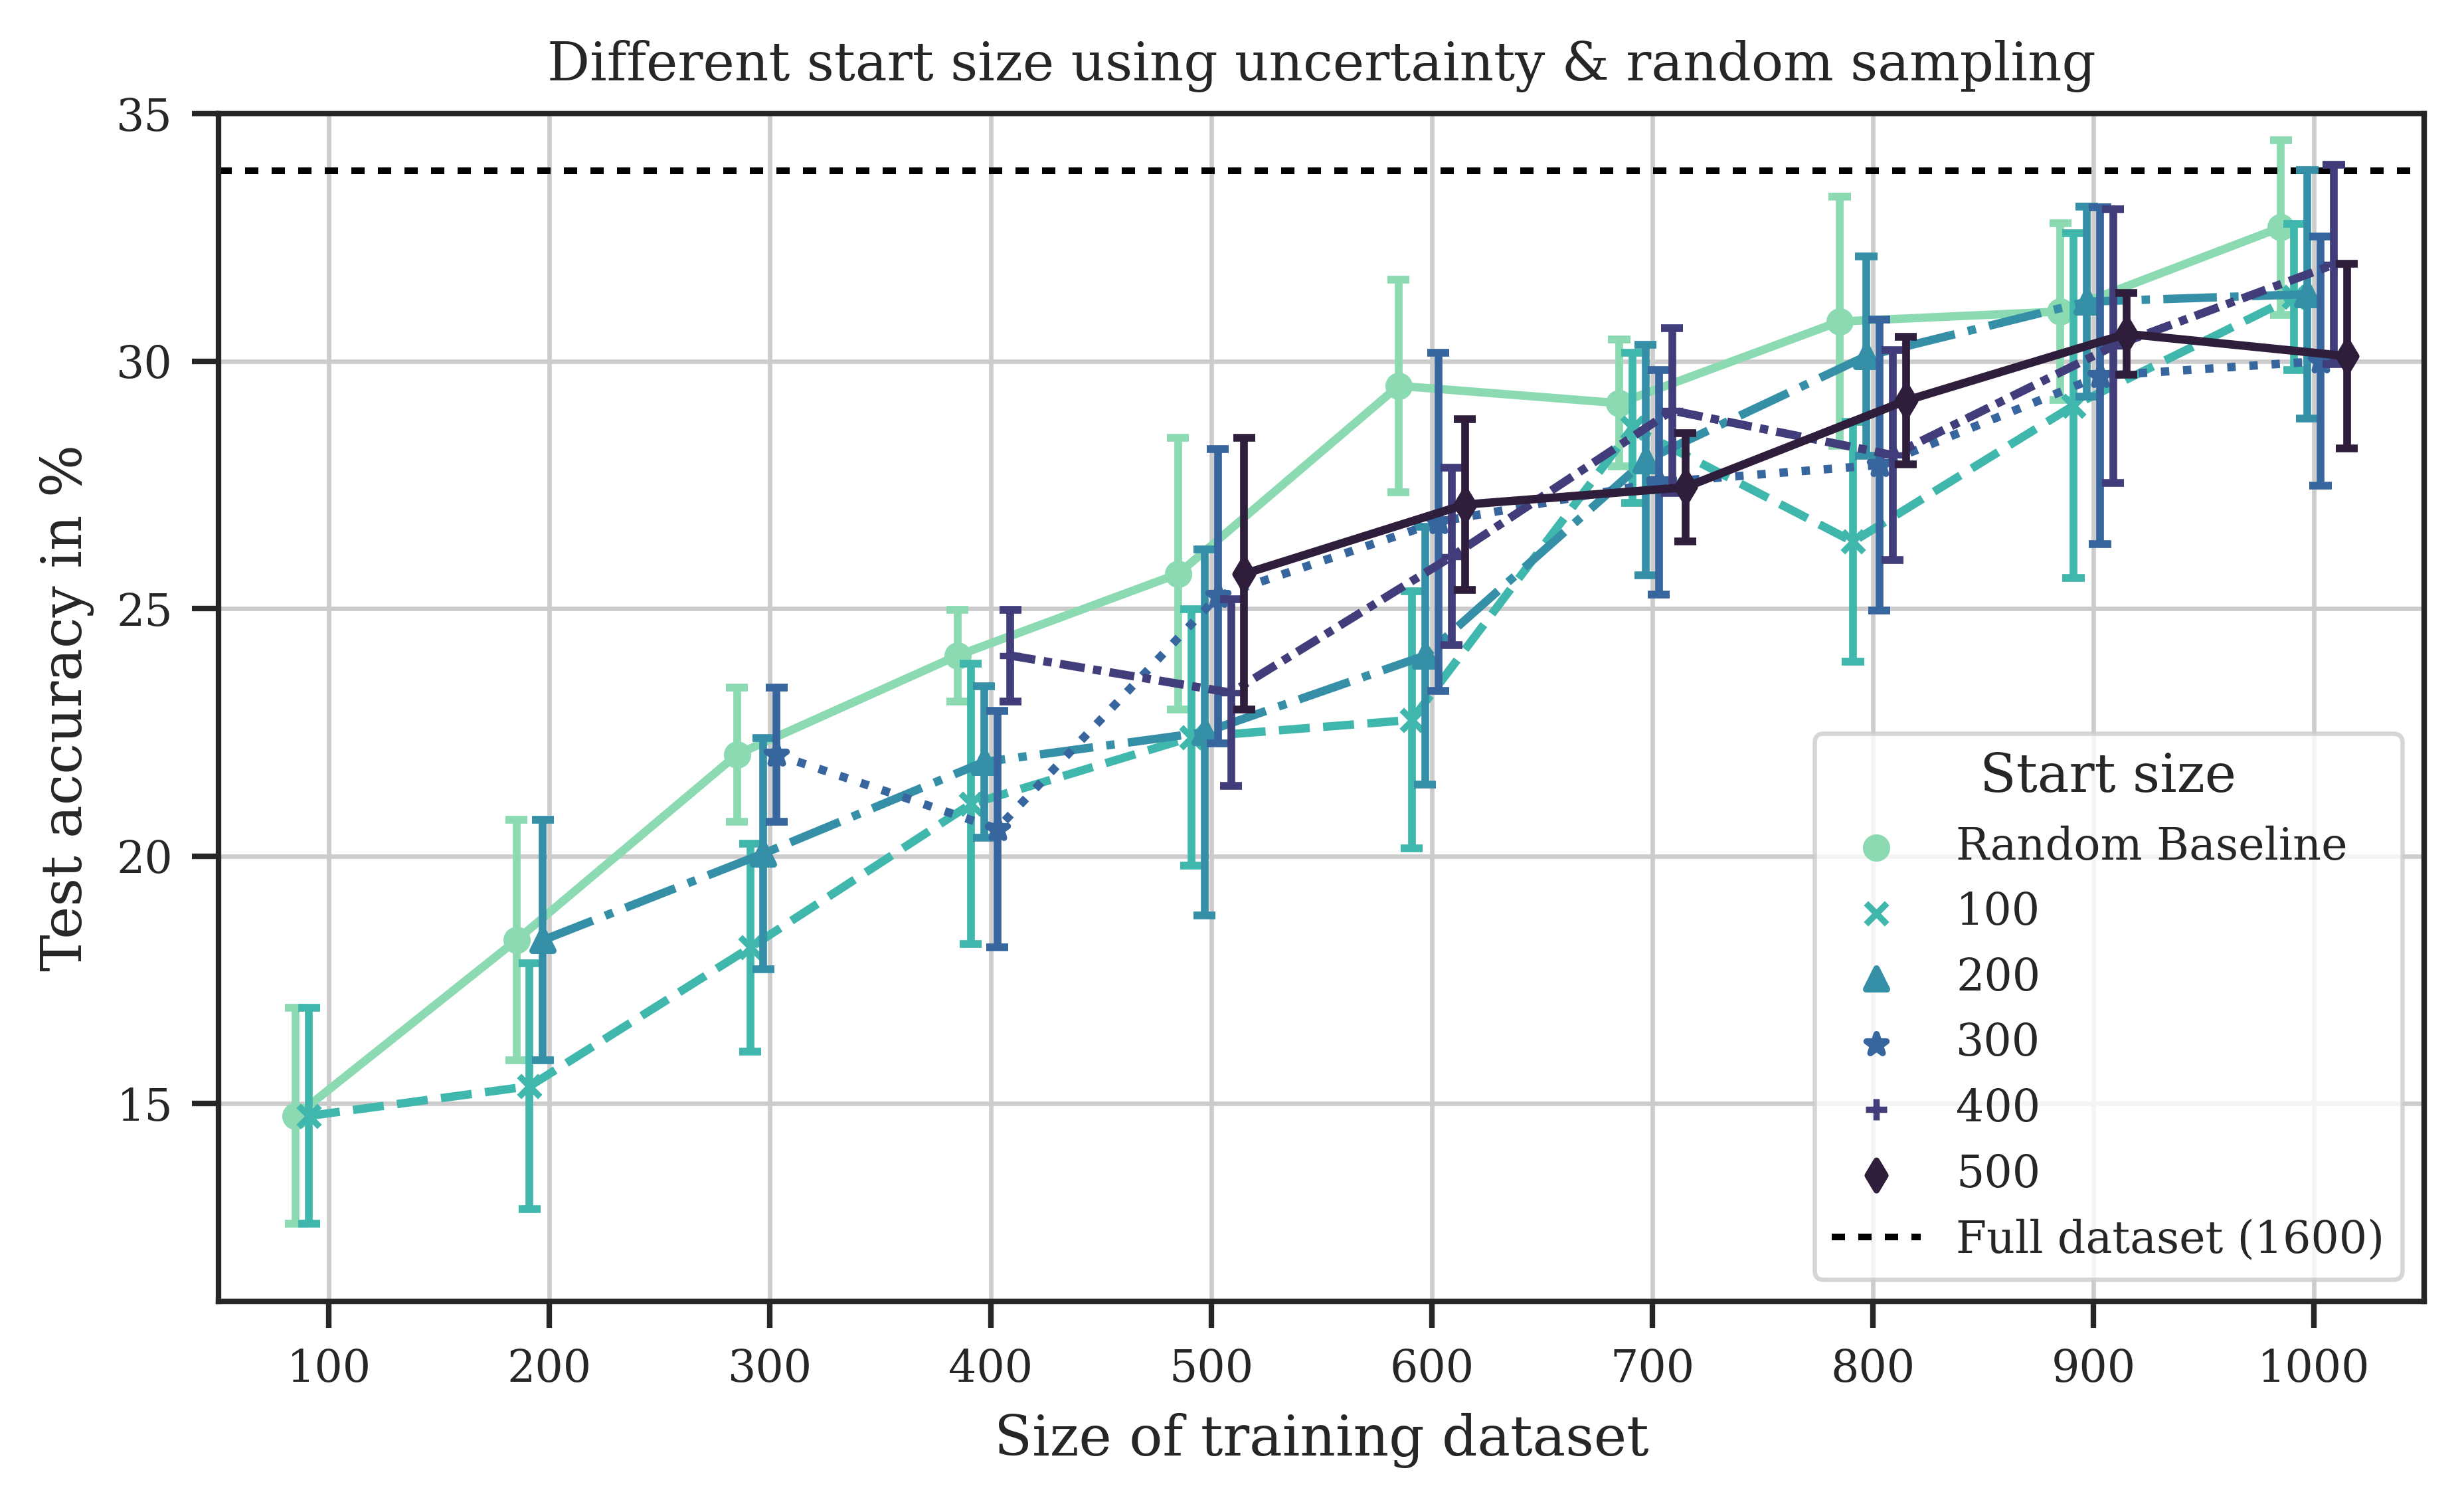

In [3]:
###############
# Start Value #
###############
set_style()
linewidth = 0.7
full_path = os.path.join("docs/results", "Simple")
save_path = os.path.join("docs/results", "ESC50_starts")
full = [
    os.path.join(dirpath, f)
    for (dirpath, dirnames, filenames) in os.walk(os.path.join(full_path, "1600"))
    for f in filenames
]

full_df = concat_results(full)
full = full_df[full_df["last_model"] == True]
full_mean = full.test_acc.mean()

palette = sns.color_palette("mako_r", 6)
al_text=["uncertainty", "uncertainty & random"]
for i, al_method in enumerate(["Uncertainty", "Uncertain+Random"]):
    df=None
    dfs = find_csv(save_path, starts="1000")
    for path in dfs:
        new_df = pd.read_csv(path, index_col=0)
        if path.split(os.sep)[2].startswith("st_"):
            start_val = path.split(os.sep)[2][3:]
            new_df["Start"] = start_val
            new_df = new_df[new_df['ActiveLearn'] == al_method]
            new_df = new_df[new_df['train_size'] >= int(start_val)]
        else:
            new_df["Start"] = "Random Baseline"
        df = result_handler(df, new_df)

    plt.figure(figsize=(set_size("project", fraction=1)))
    df = df[df["last_model"] == True]
    sns.set_palette(palette)
    g = sns.pointplot(
        data=df,
        x="train_size",
        y="test_acc",
        hue="Start",
        errorbar=("se", 2),  # Noneparametric
        scale=linewidth,
        dodge=0.3,
        errwidth=linewidth * 2,
        capsize=0.1,
        markers=["o", "x","^","*","+", "d"],
        linestyles=["-", "--", "-.", ":", (0, (3, 1, 1, 1)), "-"],
    )
    g.axhline(full_mean, label="Full dataset (1600)", dashes=[2, 2], color="black")
    g.set(
        title=f"Different start size using {al_text[i]} sampling",
        xlabel="Size of training dataset",
        ylabel="Test accuracy in %",
        ylim=(11.0, 35.0),
    )
    handles, labels = g.get_legend_handles_labels()
    plt.grid(True)
    plt.legend(handles=handles, labels=labels, title="Start size", loc="lower right")
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"results_{al_method}.png"))
    plt.savefig(os.path.join(save_path, f"results_{al_method}.eps"))
    full["Start"] = "Full"
    make_latex(
        os.path.join(save_path, f"start_{al_method}.tex"), pd.concat([full, df], axis=0)
    )

